In [ ]:
#import dependency
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import requests

import psycopg2
import config as creds


In [ ]:
def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                 +" password="+ creds.PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    #print("Connected!")

    #Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor


In [ ]:
# Connecting to DB

conn, cursor = connect()

# SQL command to create inventory table
sql = "select * from ames;"
#cursor.execute(sql)
df = pd.read_sql_query(sql, conn)
#conn.commit()
# dat = pd.read_sql_query(sql, conn)

In [ ]:
df

,ames_order,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,...,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NA,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NA,GdPrv,NA,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NA,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,...,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NA,MnPrv,NA,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,...,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NA,NA,NaN,NA,0.0,0.0,NA,NA,Y,80,32,0,0,0,0,NA,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NA,Reg,Lvl,AllPub

# **Connect to AWS Database using spark**

# **Step 1: Data Exploration**
* Check the dataset
* check the missing values and duplicates
* check the columns
* check the types
* check the shape

In [ ]:
df.dtypes

ames_order         int64
pid               object
mssubclass        object
mszoning          object
lotfrontage      float64
                  ...   
mosold             int64
yrsold             int64
saletype          object
salecondition     object
saleprice          int64
Length: 82, dtype: object

**Data Explorarion Summary:**
* There are multiple types of features, both categorical and numerical
* Tratget is numerical
* There are missing values in the dataset



# **Step 2: Feature Selection:**
* Use heatmap to identify features that are most correlated to the Sales Price


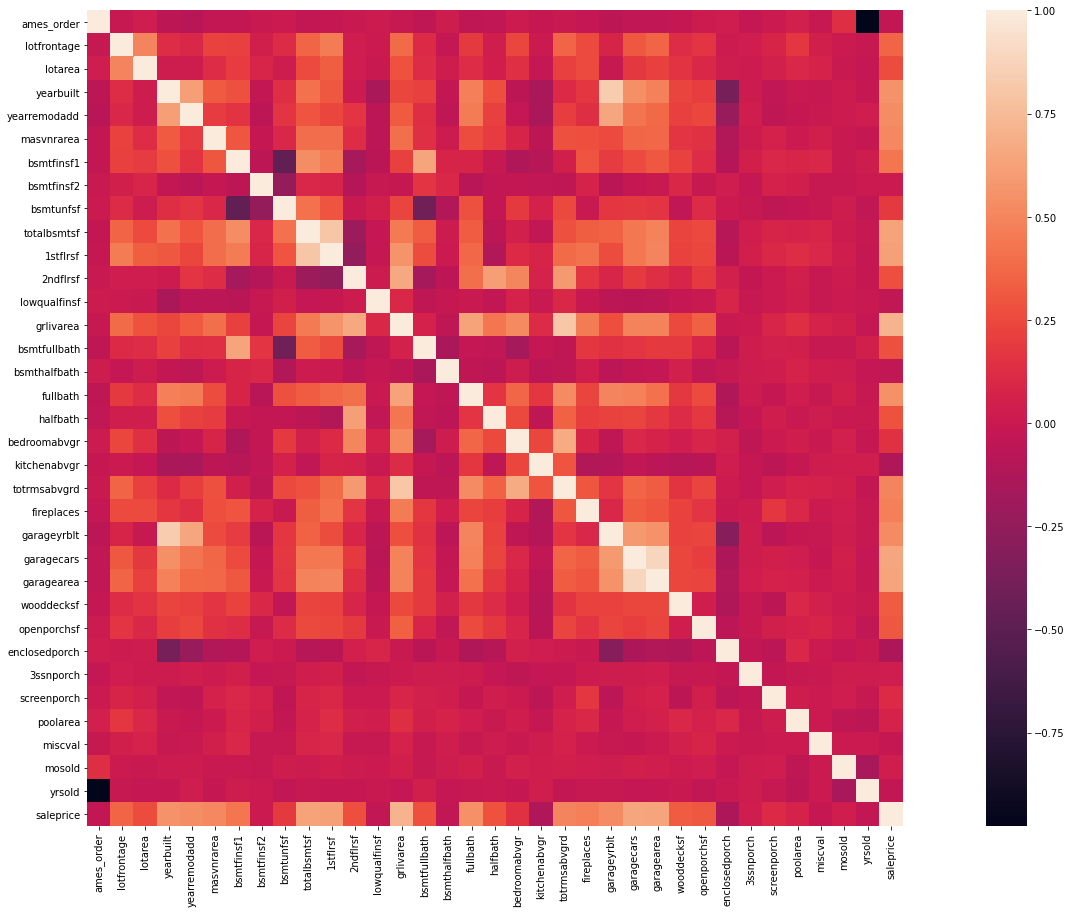

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(corrmat, vmax=1, square=True)


In [ ]:
corrmat_2 = corrmat['saleprice'].sort_values(ascending=False).head(12).to_frame()

cm = sns.light_palette("purple", as_cmap=True)

corrmat_3 = corrmat_2.style.background_gradient(cmap=cm)
corrmat_3



,saleprice
saleprice,1.000000
grlivarea,0.706780
garagecars,0.647877
garagearea,0.640401
totalbsmtsf,0.632280
1stflrsf,0.621676
yearbuilt,0.558426
fullbath,0.545604
yearremodadd,0.532974
garageyrblt,0.526965


# **Features Selected**
In total, we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5)

* overallqual_id
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* LotConfig
* Neighborhood
* BldgType
* Foundation



# **Step 3: Data cleaning:**

* remove null value or replace it with the mode of their respective columns
* remove duplicate if any
* check histogram and see if they are normally distributed in order to be used in linear regression model
* transform the skewed numeric features by taking log(feature + 1) -->make features more normally distributed
* create new feature to combine features that are in the same category
* transform categorical features using Encode Labels

*Note: some date cleaning has been done using SQL. (please refer to the SQL script. (ex. PoolQC NA have been replaced with 0 to mean No Pool) *italicized text*

In [ ]:
# combine train and test dataset
df.shape[0]
df.columns
#Drop the ames_order, pid column since it doesn't help with prediction
df.drop(columns=["ames_order","pid"], axis=1, inplace=True)
df


,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,20,RL,141.0,31770,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,80,RL,37.0,7937,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,Y,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NA,Detchd,1984.0,Unf,2.0,588.0,TA,TA,Y,120,0,0,0,0,0,NA,GdPrv,NA,0,3,2006,WD,Normal,142500
2926,20,RL,NaN,8885,Pave,NA,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,Y,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1983.0,Unf,2.0,484.0,TA,TA,Y,164,0,0,0,0,0,NA,MnPrv,NA,0,6,2006,WD,Normal,131000
2927,85,RL,62.0,10441,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NA,NA,NaN,NA,0.0,0.0,NA,NA,Y,80,32,0,0,0,0,NA,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,20,RL,77.0,10010,Pave,NA,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1974,1975,Gable,CompShg,HdBoard,HdBoard,None,0.

**check if target is normally distributed**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


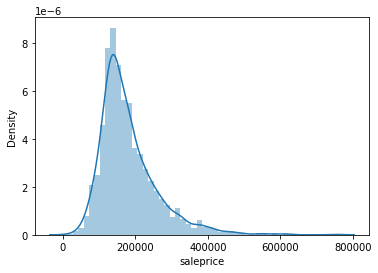

In [ ]:
# check if saleprice is normally distributed in order to be used in our Multiple linear regression model later
sns.distplot(df['saleprice']);
#we can see the saleprice is right skewed

# transform the the saleprice by taking log to make the data more normally distribute
df['saleprice'] = np.log1p(df['saleprice'])


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


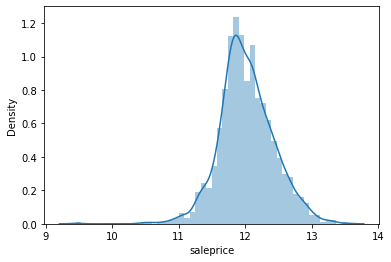

In [ ]:
#Check the new distribution to make sure its transformed
sns.distplot(df['saleprice']);

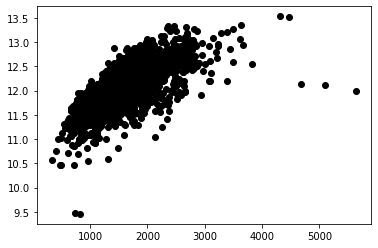

In [ ]:
#check the outlier from grlivarea
plt.scatter(y =df.saleprice,x = df.grlivarea,c = 'black')
plt.show()

In [ ]:
#check missing data ratio
missing_2 = (df.isnull().sum()/ len(df)) * 100
missing_2 = missing_2.drop(missing_2[missing_2 ==0].index).sort_values(ascending=False)[:30]
missing_2

lotfrontage     16.723549
garageyrblt      5.426621
masvnrarea       0.784983
masvnrtype       0.784983
bsmthalfbath     0.068259
bsmtfullbath     0.068259
garagearea       0.034130
garagecars       0.034130
electrical       0.034130
totalbsmtsf      0.034130
bsmtunfsf        0.034130
bsmtfinsf2       0.034130
bsmtfinsf1       0.034130
dtype: float64

**Further cleaning of the dataset imported from database**


In [ ]:
#Replace null values with o for garageyrblt, garagearea and garagecars with 0
for col in ('garageyrblt', 'garagearea', 'garagecars'):
  df[col] = df[col].fillna(0)

In [ ]:
#Fill missing values in masvnrarea and masvnrtype with mode
df['masvnrarea'].value_counts()
df['masvnrarea'] = df['masvnrarea'].fillna(df['masvnrarea'].mode()[0])
df['masvnrtype'].value_counts()
df['masvnrtype'] = df['masvnrtype'].fillna(df['masvnrtype'].mode()[0])

In [ ]:
df['bsmthalfbath'].value_counts()
df['bsmthalfbath'] = df['bsmthalfbath'].fillna(df['bsmthalfbath'].mode()[0])
df['bsmtfullbath'].value_counts()
df['bsmtfullbath'] = df['bsmtfullbath'].fillna(df['bsmtfullbath'].mode()[0])

In [ ]:
# null values saleprice are due to missing saleprice column in the test dataset
# we will replace missing values in lotfrontage with median lotfrontage of neighberhood 
df['lotfrontage'] = df.groupby('neighborhood')['lotfrontage'].transform(
      lambda x: x.fillna(x.median()))

In [ ]:

df["utilities"].value_counts()
# drop the entire column since it only doesn't help with prediction
df = df.drop(['utilities'], axis=1)


In [ ]:
df["electrical"].value_counts()
df["electrical"] = df["electrical"].fillna(df["electrical"].mode()[0])

In [ ]:
basement = ["totalbsmtsf", "bsmtunfsf", "bsmtfinsf2", "bsmtfinsf1"]
for i in basement:
  print(df[i].value_counts())
  df[i] = df[i].fillna(df[i].mode()[0])

0.0       79
864.0     74
672.0     29
912.0     26
1040.0    25
          ..
811.0      1
1958.0     1
1615.0     1
1765.0     1
1967.0     1
Name: totalbsmtsf, Length: 1058, dtype: int64
0.0       244
384.0      19
728.0      14
672.0      13
600.0      12
         ... 
1380.0      1
439.0       1
227.0       1
303.0       1
1851.0      1
Name: bsmtunfsf, Length: 1137, dtype: int64
0.0      2578
294.0       5
180.0       5
72.0        3
435.0       3
         ... 
35.0        1
154.0       1
106.0       1
488.0       1
530.0       1
Name: bsmtfinsf2, Length: 274, dtype: int64
0.0       930
24.0       27
16.0       14
300.0       9
288.0       8
         ... 
914.0       1
1836.0      1
874.0       1
337.0       1
696.0       1
Name: bsmtfinsf1, Length: 995, dtype: int64


In [ ]:
df.duplicated().sum()

0

In [ ]:
#Convert numerical categories that shouldn't be numerical to categorical categories
#please refer to the description file for definition of each category
df['mssubclass'] = df['mssubclass'].astype(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)
df['overallcond'] = df['overallcond'].astype(str)
df['overallqual'] = df['overallqual'].astype(str)
df.dtypes

mssubclass        object
mszoning          object
lotfrontage      float64
lotarea            int64
street            object
                  ...   
mosold            object
yrsold            object
saletype          object
salecondition     object
saleprice        float64
Length: 79, dtype: object

In [ ]:
# combine an important feature
df['total_area'] = df['totalbsmtsf'] + df['1stflrsf'] + df['2ndflrsf'] + df['grlivarea'] + df['garagearea']

**check both numerical and categorical columns before further processing**

In [ ]:
numerical = df.select_dtypes(exclude='object')
numerical.columns

Index(['lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf',
       '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
       'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'saleprice', 'total_area'],
      dtype='object')

In [ ]:
categorical = df.select_dtypes('object')
categorical.columns

Index(['mssubclass', 'mszoning', 'street', 'alley', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
       'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype',
       'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc',
       'fence', 'miscfeature', 'mosold', 'yrsold', 'saletype',
       'salecondition'],
      dtype='object')

**check if other numerical features are normally distributed**

In [ ]:
from scipy.stats import skew 
skewness = numerical.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)


miscval          21.988523
poolarea         16.930469
lotarea          12.814334
lowqualfinsf     12.111957
3ssnporch        11.397956
kitchenabvgr      4.311616
bsmtfinsf2        4.138674
enclosedporch     4.012390
screenporch       3.955441
bsmthalfbath      3.940371
masvnrarea        2.617964
openporchsf       2.534088
wooddecksf        1.841735
1stflrsf          1.468676
bsmtfinsf1        1.415696
total_area        1.319018
grlivarea         1.273457
totalbsmtsf       1.150257
bsmtunfsf         0.922572
2ndflrsf          0.866013
totrmsabvgrd      0.753157
fireplaces        0.738837
halfbath          0.697356
bsmtfullbath      0.617411
bedroomabvgr      0.305538
garagearea        0.239942
fullbath          0.171864
saleprice        -0.014765
garagecars       -0.221049
yearremodadd     -0.451631
yearbuilt        -0.604153
garageyrblt      -3.914938
lotfrontage            NaN
dtype: float64

In [ ]:
#normalize the data by taking log
skewness = np.log(skewness)
skewness.sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


miscval          3.090521
poolarea         2.829115
lotarea          2.550564
lowqualfinsf     2.494193
3ssnporch        2.433434
kitchenabvgr     1.461313
bsmtfinsf2       1.420375
enclosedporch    1.389387
screenporch      1.375092
bsmthalfbath     1.371275
masvnrarea       0.962397
openporchsf      0.929834
wooddecksf       0.610708
1stflrsf         0.384361
bsmtfinsf1       0.347621
total_area       0.276888
grlivarea        0.241736
totalbsmtsf      0.139985
bsmtunfsf       -0.080589
2ndflrsf        -0.143855
totrmsabvgrd    -0.283482
fireplaces      -0.302678
halfbath        -0.360459
bsmtfullbath    -0.482220
bedroomabvgr    -1.185682
garagearea      -1.427359
fullbath        -1.761052
lotfrontage           NaN
yearbuilt             NaN
yearremodadd          NaN
garageyrblt           NaN
garagecars            NaN
saleprice             NaN
dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


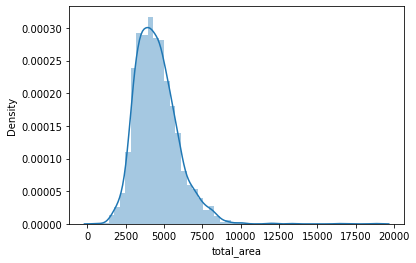

In [ ]:
#check the distribution of total_area
sns.distplot(df['total_area']);


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


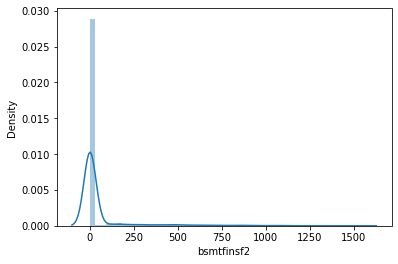

In [ ]:
#check the distribution of bsmtdinsf2
sns.distplot(df['bsmtfinsf2']);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


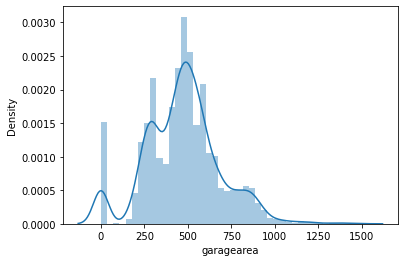

In [ ]:
#check the distribution of garagearea
sns.distplot(df['garagearea']);

**should we do box cox tranform to further normalize it? skewness > 0.75**

**Process categorical features using Label Encoding**


In [ ]:
#transform text into numerical data by applying LabelEncoder 
from sklearn.preprocessing import LabelEncoder
cols = ('mssubclass', 'mszoning', 'street', 'alley', 'lotshape', 'landcontour',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'overallqual', 'overallcond', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual',
       'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
       'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair',
       'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype',
       'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc',
       'fence', 'miscfeature', 'mosold', 'yrsold', 'saletype',
       'salecondition')

for col in cols:
  le = LabelEncoder()
  le.fit(list(df[col].values))
  df[col] = le.fit_transform(list(df[col].values))
df.shape  

(2927, 80)

In [ ]:
df.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,total_area
0,5,5,141.0,31770,1,1,0,3,0,0,13,2,2,0,2,6,4,1960,1960,3,1,3,10,4,112.0,3,4,1,5,2,1,1,639.0,6,0.0,441.0,1080.0,1,1,1,4,1656,0,0,1656,1.0,0.0,1,0,3,1,4,7,7,2,2,1,1960.0,0,2.0,528.0,5,5,1,210,62,0,0,0,0,3,4,2,0,7,4,9,4,12.278398,4920.0
1,5,4,80.0,11622,1,1,3,3,4,0,13,1,2,0,2,5,5,1961,1961,1,1,13,14,3,0.0,3,4,1,5,5,4,5,468.0,3,144.0,270.0,882.0,1,4,1,4,896,0,0,896,0.0,0.0,1,0,2,1,4,5,7,0,3,1,1961.0,3,1.0,730.0,5,5,2,140,0,0,0,120,0,3,2,2,0,8,4,9,4,11.561725,3404.0
2,5,5,81.0,14267,1,1,0,3,0,0,13,2,2,0,2,6,5,1958,1958,3,1,14,15,1,108.0,3,4,1,5,5,4,0,923.0,6,0.0,406.0,1329.0,1,4,1,4,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,7,0,3,1,1958.0,3,1.0,312.0,5,5,2,393,36,0,0,0,0,3,4,1,12500,8,4,9,4,12.055256,4299.0
3,5,5,93.0,11160,1,1,3,3,0,0,13,2,2,0,2,7,4,1968,1968,3,1,3,3,3,0.0,2,4,1,5,5,4,0,1065.0,6,0.0,1045.0,2110.0,1,0,1,4,2110,0,0,2110,1.0,0.0,2,1,3,1,0,8,7,2,5,1,1968.0,0,2.0,522.0,5,5,2,0,0,0,0,0,0,3,4,2,0,6,4,9,4,12.404928,6852.0
4,10,5,74.0,13830,1,1,0,3,4,0,8,2,2,0,5,5,4,1997,1998,1,1,13,14,3,0.0,3,4,2,2,5,4,2,791.0,6,0.0,137.0,928.0,1,2,1,4,928,701,0,1629,0.0,0.0,2,1,3,1,4,6,7,1,5,1,1997.0,0,2.0,482.0,5,5,2,212,34,0,0,0,0,3,2,2,0,5,4,9,4,12.154258,4668.0


# **Step 4: Multiple Linear Regression Model: Predict house prices based on the selected features**
* Split the data into train and test (X:features, y=target)
* Scale the data
* Create an instance of the model with model = LinearRegression().
* Train the model with the dataset with model.fit(X,y)
* Create predictions with y_pred = model.predict(X)


In [ ]:
#Determine features and target
feature = df.drop(columns=['saleprice'])
target = df['saleprice']

print(feature)
print(target)

      mssubclass  mszoning  lotfrontage  ...  saletype  salecondition  total_area
0              5         5        141.0  ...         9              4      4920.0
1              5         4         80.0  ...         9              4      3404.0
2              5         5         81.0  ...         9              4      4299.0
3              5         5         93.0  ...         9              4      6852.0
4             10         5         74.0  ...         9              4      4668.0
...          ...       ...          ...  ...       ...            ...         ...
2925          13         5         37.0  ...         9              4      3597.0
2926           5         5         74.0  ...         9              4      3152.0
2927          14         5         62.0  ...         9              4      2852.0
2928           5         5         77.0  ...         9              4      4585.0
2929          10         5         74.0  ...         9              4      5646.0

[2927 rows x 79

# **Features Selected**
In total, we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5). We also added another additional features: total_area

* overallqual
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd
* ADDED total_area

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* lotconfig
* neighborhood
* bldgtype
* foundation


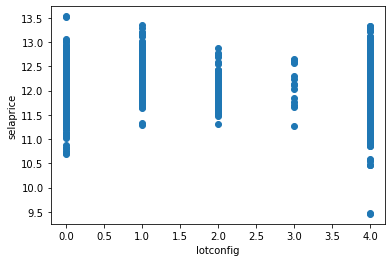

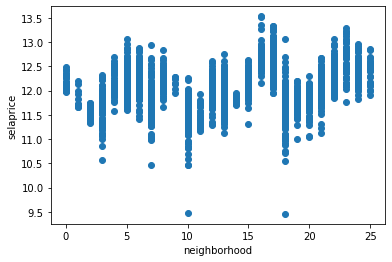

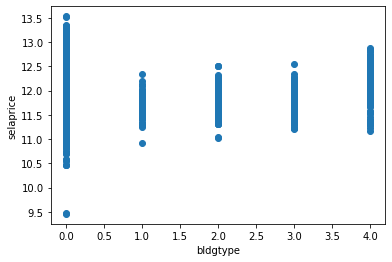

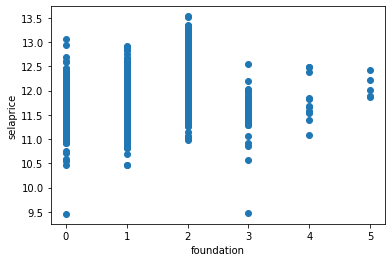

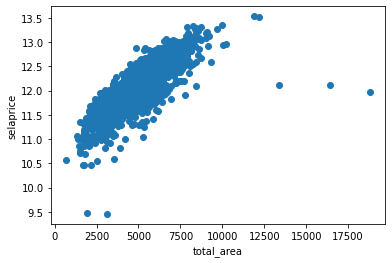

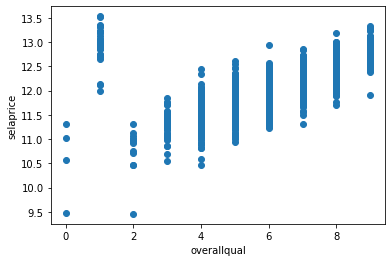

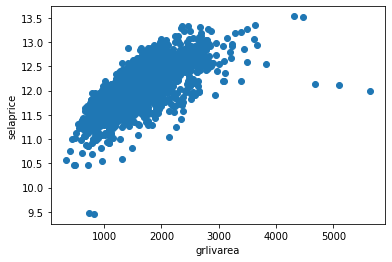

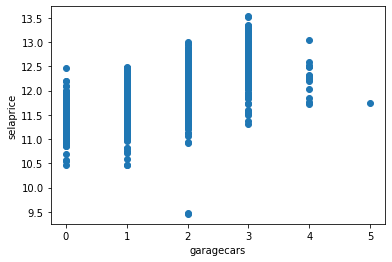

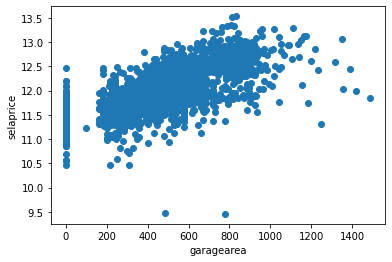

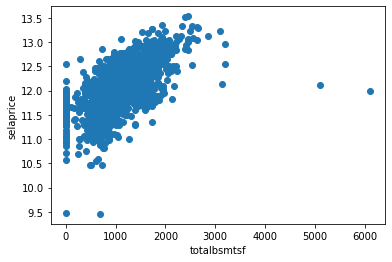

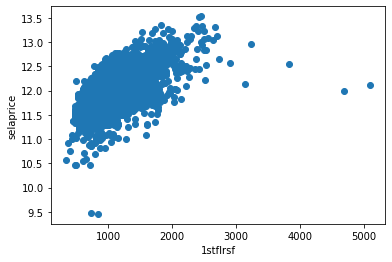

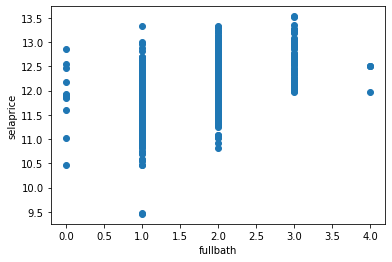

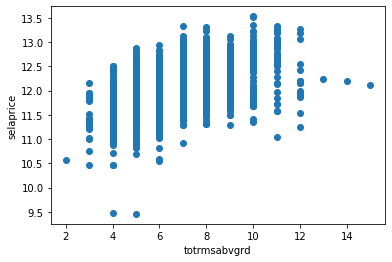

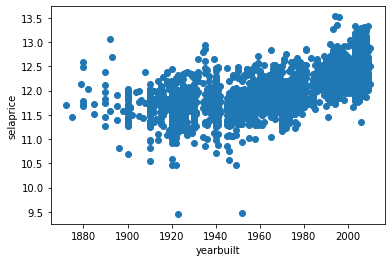

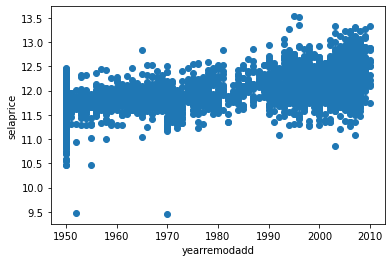

In [ ]:
x_features = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
for x in x_features:

  plt.scatter(df[x], df['saleprice'])
  plt.xlabel(x)
  plt.ylabel('selaprice')
  plt.show()

In [ ]:
#dropping any NA before putting the dataset into our model
df = df.dropna()
df.isnull().sum()

mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
street           0
                ..
yrsold           0
saletype         0
salecondition    0
saleprice        0
total_area       0
Length: 80, dtype: int64

# **Machine Learning Model**

**Import library**

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df.columns

Index(['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'housestyle', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl',
       'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual',
       'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
       'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf',
       'totalbsmtsf', 'heating', 'heatingqc', 'centralair', 'electrical',
       '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces',
       'fireplacequ', 'garagetype', 'garageyrblt', 'garagefinish',
       'garagecars', 'garagearea', 'garagequal', 'garagecond', 'paveddrive',
       'wooddecksf', 'o

Pick features and scale the data

In [ ]:
#put our selected features into a list
cols = ['mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'housestyle', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl',
       'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea', 'exterqual',
       'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
       'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf',
       'totalbsmtsf', 'heating', 'heatingqc', 'centralair', 'electrical',
       '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces',
       'fireplacequ', 'garagetype', 'garageyrblt', 'garagefinish',
       'garagecars', 'garagearea', 'garagequal', 'garagecond', 'paveddrive',
       'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch',
       'screenporch']
#cols = ["lotconfig", "neighborhood", "bldgtype", "foundation","total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
#try using only the numerical category
#cols = ["total_area","overallqual","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]#


#assign y to our target and x to our features 
y = df['saleprice'].values
X = df[cols]

#try using all the columns as features
# X = df.loc[:, df.columns != 'saleprice']

#scale the data
X_scaled = preprocessing.StandardScaler().fit_transform(X)
y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))


**Perform 80/20 data split**

In [ ]:
#data is split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state= 0)
#check the shape of each set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2341, 69), (586, 69), (2341, 1), (586, 1))

**Linear Regression Model**

In [ ]:
#define the model
model = linear_model.LinearRegression()
#build training model -->start time 
model.fit(X_train, y_train)
#-->end
#run prediction on test set 
y_test_pred = model.predict(X_test)


# print(y_test_pred.shape)


**Model Performance**

In [ ]:
#print the coefficient, intercept, MSE and model score(R^2)
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")
print(f"Mean squared Error(MSE): {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"Coefficient of Determination(R^2): {r2_score(y_test, y_test_pred):.2f}")

Coefficients: [[ 2.22209343e-02 -1.95611212e-02 -1.91720661e-02  2.29339814e-02
   2.65735405e-02  1.33913047e-02 -1.93312449e-02  1.05450846e-02
   3.53231473e-03  3.09302106e-02  2.42963493e-02 -4.94969367e-06
  -1.73808186e-03 -5.15182240e-02 -3.82773058e-02  1.54335299e-01
   1.31394551e-01  1.44016940e-01  3.53852517e-02  2.23886004e-02
   1.49580045e-02 -2.82686491e-02  2.98927388e-02  1.21853562e-02
   1.86826992e-02 -7.22550246e-02  3.30665658e-02  1.54814971e-02
  -2.34096173e-02  1.21998335e-02 -4.35219897e-02 -3.08752682e-02
  -1.79587359e+11  1.78632736e-02 -6.67070713e+10 -1.73286702e+11
   1.73689688e+11  2.34246254e-03 -3.07304859e-02  5.03234863e-02
   1.31893158e-03  4.92728850e+11  5.38700180e+11  5.82533696e+10
  -6.35844639e+11  5.12657166e-02 -3.55243683e-03  4.17709351e-02
   8.47196579e-03 -1.14307702e-02 -3.82194519e-02 -5.04975319e-02
   3.66104841e-02  3.92131805e-02  6.93187714e-02 -2.16693878e-02
  -3.99856567e-02 -1.05810165e-02 -1.26304626e-02  1.13459587e

**Make a scatter plot**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gboostRegressorModel = GradientBoostingRegressor(n_estimators=2500, random_state =0)
gboostRegressorModel.fit(X_train,y_train)
gboost_trainscore=gboostRegressorModel.score(X_train, y_train)
print("Training Accuracy of GradientBoosting Regression:",gboost_trainscore)

# Predict new result
y_pred_gbr = gboostRegressorModel.predict(X_test)

gboost_testscore=gboostRegressorModel.score(X_test, y_test)
print("Testing Accuracy of GradientBoosting Regression:",gboost_testscore)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy of GradientBoosting Regression: 0.9990680235679184
Testing Accuracy of GradientBoosting Regression: 0.9080086529665652


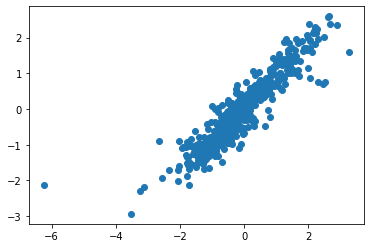

In [ ]:
plt.scatter(y_test, y_test_pred)
plt.show()



In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model = tf.keras.models.Sequential()

nn_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
nn_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
nn_model.summary()
nn_model.compile(loss="mean_squared_error", optimizer="adam")
#start--neural
nn_model.fit(X_train_scaled, np.asarray(y_train), epochs=100)
#end
y_train_pred = nn_model.predict(X_train_scaled)
y_test_pred = nn_model.predict(X_test_scaled)

deep_model = tf.keras.models.Sequential()
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu", input_dim = len(X.columns)))
deep_model.add(tf.keras.layers.Dense(units=len(X.columns) * 2, activation = "relu"))
deep_model.add(tf.keras.layers.Dense(units=1, activation="linear"))
deep_model.summary()

deep_model.compile(loss="mean_squared_error", optimizer="adam")
#start--deep
deep_model.fit(X_train_scaled, np.asarray(y_train), epochs=100)
#end
y_train_pred = deep_model.predict(X_train_scaled)
y_test_pred = deep_model.predict(X_test_scaled)

#1st model + time VS 2nd model + time


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 22)                264       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 23        
Total params: 287
Trainable params: 287
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
74/74 [==============================] - 0s 981us/step - loss: 0.9951
Epoch 2/100
74/74 [==============================] - 0s 809us/step - loss: 0.7126
Epoch 3/100
74/74 [==============================] - 0s 852us/step - loss: 0.5689
Epoch 4/100
74/74 [==============================] - 0s 885us/step - loss: 0.4535
Epoch 5/100
74/74 [==============================] - 0s 957us/step - loss: 0.3680
Epoch 6/100
74/74 [==============================] - 0s 980us/step - loss: 0.3102
Epoch 7/100
74/74 [=======

In [ ]:
print(r2_score(y_train, y_train_pred))
print(r2_score(y_test, y_test_pred))

0.863839914074455
0.881061653578849


# **Models Comparison - R^2**
**Multiple Linear Regression**


*   11 features-->0.84
*   15 features-->0.85
*   79 features-->0.88

**Deep Learning**


*   11 features-->0.86
*   15 features-->0.88
*   79 features-->0.89